# 1 Business Problem

- Which product categories has lower reviews / maybe inferior products? (ie. electronics, iPad)
- Which product have higher reviews / maybe superior products?
    
Business solutions:
- **Which products should be kept, dropped from Amazon's product roster (which ones are junk?)**
- **Also: can we associate positive and negative words/sentiments for each product in Amazon's Catalog**
- By using Sentiment analysis, can we predict scores for reviews based on certain words

This dataset is based on Amazon branded/Amazon manufactured products only, and Customer satisfaction with Amazon products seem to be the main focus here.

Potential suggestion for product reviews:
<br>Product X is highly rated on the market, it seems most people like its lightweight sleek design and fast speeds. Most products that were associated with negative reviews seemed to indicate that they were too heavy and they couldn't fit them in the bags. We suggest that next gen models for e-readers are lightweight and portable, based on this data we've looked at.

Assumptions:
- We're assuming that sample size of 30K examples are sufficient to represent the entire population of sales/reviews
- We're assuming that the information we find in the text reviews of each product will be rich enough to train a sentiment analysis classifier with accuracy (hopefully) > 70%

# 2 Quick Look at the Raw Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import warnings

warnings.filterwarnings('ignore') 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
sns.set_style("whitegrid") 
%matplotlib inline
np.random.seed(7) 

csv = "dataset.csv"
df = pd.read_csv(csv)
df.head(2)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman


- We can potentially refine sentiment analysis with the reviews.text column, with the actual rating of reviews.doRecommend column (boolean)
- We can also label each review based on each sentiment
    - title can contain positive/negative information about review

In [2]:
data = df.copy()
data.describe()

,reviews.id,reviews.numHelpful,reviews.rating,reviews.userCity,reviews.userProvince
count,1.0,34131.000000,34627.000000,0.0,0.0
mean,111372787.0,0.630248,4.584573,NaN,NaN
std,NaN,13.215775,0.735653,NaN,NaN
min,111372787.0,0.000000,1.000000,NaN,NaN
25%,111372787.0,0.000000,4.000000,NaN,NaN
50%,111372787.0,0.000000,5.000000,NaN,NaN
75%,111372787.0,0.000000,5.000000,NaN,NaN
max,111372787.0,814.000000,5.000000,NaN,NaN


Based on the descriptive statistics above, we see the following:
- Average review score of 4.58, with low standard deviation
    - Most review are positive from 2nd quartile onwards
- The average for number of reviews helpful (reviews.numHelpful) is 0.6 but high standard deviation
    - The data are pretty spread out around the mean, and since can't have negative people finding something helpful, then this is only on the right tail side
    - The range of most reviews will be between 0-13 people finding helpful (reviews.numHelpful)
- The most helpful review was helpful to 814 people
    - This could be a detailed, rich review that will be worth looking at

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

Based on the information above:
- Drop reviews.userCity, reviews.userProvince, reviews.id, and reviews.didPurchase since these values are floats (for exploratory analysis only)
- Not every category have maximum number of values in comparison to total number of values
- reviews.text category has minimum missing data (34659/34660) -> Good news!
- We need to clean up the name column by referencing asins (unique products) since we have 7000 missing values

In [4]:
data["asins"].unique()

array(['B01AHB9CN2', 'B00VINDBJK', 'B005PB2T0S', 'B002Y27P3M',
       'B01AHB9CYG', 'B01AHB9C1E', 'B01J2G4VBG', 'B00ZV9PXP2',
       'B0083Q04TA', 'B018Y229OU', 'B00REQKWGA', 'B00IOYAM4I',
       'B018T075DC', nan, 'B00DU15MU4', 'B018Y225IA', 'B005PB2T2Q',
       'B018Y23MNM', 'B00OQVZDJM', 'B00IOY8XWQ', 'B00LO29KXQ',
       'B00QJDU3KY', 'B018Y22C2Y', 'B01BFIBRIE', 'B01J4ORNHU',
       'B018SZT3BK', 'B00UH4D8G2', 'B018Y22BI4', 'B00TSUGXKE',
       'B00L9EPT8O,B01E6AO69U', 'B018Y23P7K', 'B00X4WHP5E', 'B00QFQRELG',
       'B00LW9XOJM', 'B00QL1ZN3G', 'B0189XYY0Q', 'B01BH83OOM',
       'B00BFJAHF8', 'B00U3FPN4U', 'B002Y27P6Y', 'B006GWO5NE',
       'B006GWO5WK'], dtype=object)

In [5]:
asins_unique = len(data["asins"].unique())
print("Number of Unique ASINs: " + str(asins_unique))

Number of Unique ASINs: 42


**Visualizing the distributions of numerical variables:**

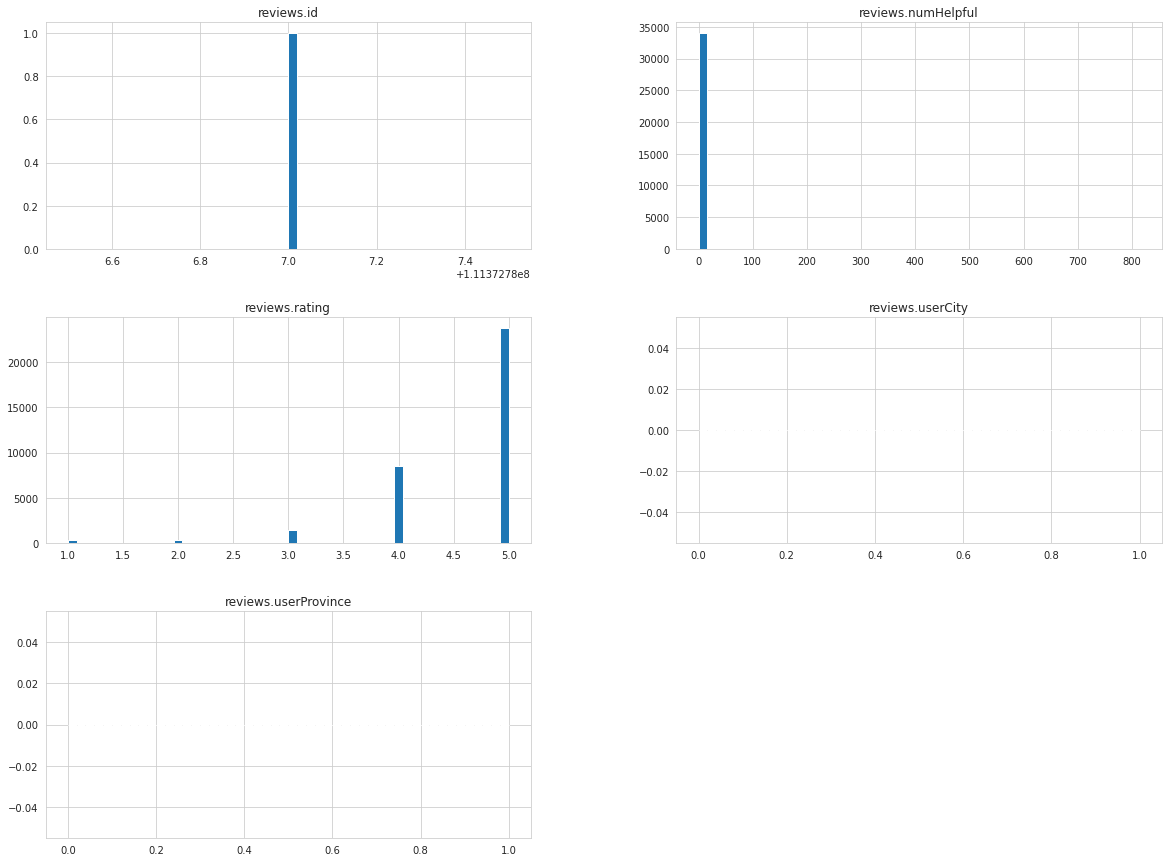

In [6]:
data.hist(bins=50, figsize=(20,15)) # builds histogram and set the number of bins and fig size (width, height)
plt.show()

Based on the distributions above:
- reviews.numHelpful: Outliers in this case are valuable, so we may want to weight reviews that had more than 50+ people who find them helpful
- reviews.rating: Majority of examples were rated highly (looking at rating distribution). There is twice amount of 5 star ratings than the others ratings combined

# 3 Split into Train/Test

- Before we explore the dataset we're going to split it into training set and test sets
- Our goal is to eventually train a sentiment analysis classifier
- Since the majority of reviews are positive (5 stars), we will need to do a stratified split on the reviews score to ensure that we don't train the classifier on imbalanced data
- To use sklearn's `Stratified ShuffleSplit` class, we're going to remove all samples that have NAN in review score, then covert all review scores to `integer` datatype

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
print("Before {}".format(len(data)))
dataAfter = data.dropna(subset=["reviews.rating"]) # removes all NAN in reviews.rating
print("After {}".format(len(dataAfter)))
dataAfter["reviews.rating"] = dataAfter["reviews.rating"].astype(int)

Before 34660
After 34627


In [8]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(dataAfter, dataAfter["reviews.rating"]): 
    strat_train = dataAfter.reindex(train_index)
    strat_test = dataAfter.reindex(test_index)

**Check to see if train/test sets were stratified proportionately in comparison to raw data.**

In [9]:
len(strat_train)

27701

In [10]:
strat_train["reviews.rating"].value_counts()/len(strat_train) # value_count() counts all the values based on column

5.0    0.685174
4.0    0.247031
3.0    0.043500
2.0    0.011696
1.0    0.011588
Name: reviews.rating, dtype: float64

In [11]:
len(strat_test)

6926

In [12]:
strat_test["reviews.rating"].value_counts()/len(strat_test)

5.0    0.689864
4.0    0.244730
3.0    0.042160
1.0    0.011406
2.0    0.011118
Name: reviews.rating, dtype: float64